In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_object_dtype
from itertools import permutations
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

##### Importing Dataset

In [2]:
df = pd.read_csv('Building_Energy_Benchmarking.csv')

#### Part 1: Data Cleaning and Preprocessing

##### 1.1 Load and Inspect the Dataset

In [3]:
#Display Shape
print('The dataset contains ' + str(df.shape[1]) + ' Columns and ' + str(df.shape[0]) + ' Rows')
print('\n')
#Display Columns
print('The dataset contains these columns: ' + str(df.columns))
print('\n')
#Display Datatypes
print('The columns of the dataset have these dataypes: \n' + str(df.dtypes))

The dataset contains 31 Columns and 494 Rows


The dataset contains these columns: Index(['Property Id', 'Property Name', 'Address 1', 'City', 'Postal Code',
       'Province', 'Primary Property Type - Self Selected',
       'Number of Buildings', 'Year Built',
       'Property GFA - Self-Reported (m²)', 'ENERGY STAR Score',
       'Site Energy Use (GJ)', 'Weather Normalized Site Energy Use (GJ)',
       'Site EUI (GJ/m²)', 'Weather Normalized Site EUI (GJ/m²)',
       'Source Energy Use (GJ)', 'Weather Normalized Source Energy Use (GJ)',
       'Source EUI (GJ/m²)', 'Weather Normalized Source EUI (GJ/m²)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kgCO2e/m²)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions Intensity (kgCO2e/m²)',
       'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (GJ)',
       'District Hot Water Use (GJ)',
       'Electricity Use – Generated from Onsite Renewable Systems (kWh)

In [4]:
#Percentage of Nulls (NaN) in each column of the dataset
for i in df.columns:
    pct = df[i].isna().sum()/len(df)
    print('The percentage of Null values for the column ' + i + ' is: ' + str(round(pct*100,1)) + '%')

The percentage of Null values for the column Property Id is: 0.0%
The percentage of Null values for the column Property Name is: 0.0%
The percentage of Null values for the column Address 1 is: 0.0%
The percentage of Null values for the column City is: 0.0%
The percentage of Null values for the column Postal Code is: 0.0%
The percentage of Null values for the column Province is: 0.0%
The percentage of Null values for the column Primary Property Type - Self Selected is: 0.0%
The percentage of Null values for the column Number of Buildings is: 0.0%
The percentage of Null values for the column Year Built is: 0.0%
The percentage of Null values for the column Property GFA - Self-Reported (m²) is: 0.0%
The percentage of Null values for the column ENERGY STAR Score is: 66.6%
The percentage of Null values for the column Site Energy Use (GJ) is: 0.0%
The percentage of Null values for the column Weather Normalized Site Energy Use (GJ) is: 0.0%
The percentage of Null values for the column Site EUI

##### 1.2 Handling Missing Data

In [5]:
#Dropping Columns with % Nulls >= 40%
thresh = 0.4
for i in df.columns:
    pct = df[i].isna().sum()/len(df)
    if pct >= thresh:
        print('Dropped Column: ' + str(i))
        df = df.drop([i],axis=1)

Dropped Column: ENERGY STAR Score
Dropped Column: District Hot Water Use (GJ)
Dropped Column: Electricity Use – Generated from Onsite Renewable Systems (kWh)
Dropped Column: Green Power - Onsite and Offsite (kWh)
Dropped Column: Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)


In [6]:
#Filling Missing Values with the Median (Numerical) or Mode (Categorical)
for i in df.columns:
    if is_numeric_dtype(df[i]):
        df[i] = df[i].fillna(df[i].median())
    else:
        df[i] = df[i].fillna(df[i].mode().iloc[0])

##### 1.3 Extracting and Cleaning Data Using RegEx

In [7]:
#Extracting Number of Data Type Mismatches on the Numerical Columns in the Dataframe
def find_wrong_dtype(df):
    """ Function to scan a dataframe and test how many values of each column contains non-alphanumerical values (e.g: "," or "."). 
    These values are frequently associated with mismatches in Data Types.
    """
    df_notna = df.copy()
    df_notna = df_notna.fillna(0)
    for col in df_notna.columns[9:-2]:
        if df_notna[col].dtype == 'object': 
            wrong_dtype_count = df_notna[col].astype(str).str.contains(r'[^0-9.\-]', regex=True).sum()
            print(f"Column: {col} | Mismatches: {wrong_dtype_count}")
    del df_notna
find_wrong_dtype(df)

#Wrangling Data Using Regex in columns with Mixed datatype (Numerical stored as Categorical)
for i in df.columns[9:-2]:
    df[i] = df[i].astype(str).str.replace(r'[,]', '', regex=True) 
    df[i] = df[i].str.replace(r'(\d+)(\d{2})$', r'\1.\2', regex=True)
    df[i] = pd.to_numeric(df[i], errors='coerce')

Column: Property GFA - Self-Reported (m²) | Mismatches: 237
Column: Site Energy Use (GJ) | Mismatches: 252
Column: Weather Normalized Site Energy Use (GJ) | Mismatches: 252
Column: Source Energy Use (GJ) | Mismatches: 262
Column: Weather Normalized Source Energy Use (GJ) | Mismatches: 262
Column: Total GHG Emissions (Metric Tons CO2e) | Mismatches: 48
Column: Direct GHG Emissions (Metric Tons CO2e) | Mismatches: 10
Column: Electricity Use - Grid Purchase (kWh) | Mismatches: 297
Column: Natural Gas Use (GJ) | Mismatches: 199


In [8]:
def standardize_postal_code(postal_code):
    """Function created to identify Postal Codes that are formatted different
    from A1A 1A1 and convert them to this format (All caps and with space)"""
    # Remove spaces and convert to uppercase
    new_pc = re.sub(r'\s+', '', postal_code).upper()  
    # Reformat to A1A 1A1 by inserting space in the middle
    return f"{new_pc[:3]} {new_pc[3:]}" if len(new_pc) == 6 else new_pc

# Applying the Function to the 'Postal Code' column
df['Postal Code'] = df['Postal Code'].apply(standardize_postal_code)

In [9]:
#Extracting from 'Property Name' items that do not seem to be Public Places (different from the majority of the dataset)
prop_types = ['Centre','Arena','Building','Station','Warehouse','Depot','Headquarters','Office','Service','Facility','Complex','EMS','School']
df['Property Name'] = df['Property Name'].astype(str)
def non_public_properties(df,prop_types):
    """This function intends to look for places with names that are not public places, as the majority of the dataframe suggests.
    The list of public places is enclosed in the variable prop_types. The output are places that do not conform with these names."""
    pattern = '|'.join(re.escape(prop) for prop in prop_types)
    non_matching = df.loc[~df['Property Name'].str.contains(pattern, case=False, na=False), 'Property Name'].unique()
    return set(non_matching)
non_public_properties(df,prop_types)

{'Ad Valorem',
 'Andrew Davison',
 'Apparatus Repair Shop and Spare Apparatus Shop',
 'Dartmouth Place',
 'Lakeview Clubhouse',
 'McHugh House'}

In [10]:
#Correcting some Abbreviations from 'Address 1'
corrections = {'AV':'Ave',
               'Av':'Ave',
               'WY':'Way',
               'DR':'Drive',
               'BV':'Blvd',
               'GA':'Gate'}
df['Address 1'] = df['Address 1'].replace(corrections,regex=True)

In [11]:
#Ensuring that all columns that we applied any RegEx rule are now ready to use in numerical form.
for i in df.columns[9:-2]:
    print('Column: ' + str(i) + ' | Datatype: ' + str(df[i].dtype))

Column: Property GFA - Self-Reported (m²) | Datatype: float64
Column: Site Energy Use (GJ) | Datatype: float64
Column: Weather Normalized Site Energy Use (GJ) | Datatype: float64
Column: Site EUI (GJ/m²) | Datatype: float64
Column: Weather Normalized Site EUI (GJ/m²) | Datatype: float64
Column: Source Energy Use (GJ) | Datatype: float64
Column: Weather Normalized Source Energy Use (GJ) | Datatype: float64
Column: Source EUI (GJ/m²) | Datatype: float64
Column: Weather Normalized Source EUI (GJ/m²) | Datatype: float64
Column: Total GHG Emissions (Metric Tons CO2e) | Datatype: float64
Column: Total GHG Emissions Intensity (kgCO2e/m²) | Datatype: float64
Column: Direct GHG Emissions (Metric Tons CO2e) | Datatype: float64
Column: Direct GHG Emissions Intensity (kgCO2e/m²) | Datatype: float64
Column: Electricity Use - Grid Purchase (kWh) | Datatype: float64
Column: Natural Gas Use (GJ) | Datatype: float64


#### Part 2: Exploratory Data Analysis (EDA) and Aggregations

##### 2.1 Statistical Summary

In [12]:
#Generating Summary Statistics using treated data - Mean, Median (50%), Min and Max
df.describe()

,Property Id,Number of Buildings,Year Built,Property GFA - Self-Reported (m²),Site Energy Use (GJ),Weather Normalized Site Energy Use (GJ),Site EUI (GJ/m²),Weather Normalized Site EUI (GJ/m²),Source Energy Use (GJ),Weather Normalized Source Energy Use (GJ),Source EUI (GJ/m²),Weather Normalized Source EUI (GJ/m²),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/m²),Direct GHG Emissions (Metric Tons CO2e),Direct GHG Emissions Intensity (kgCO2e/m²),Electricity Use - Grid Purchase (kWh),Natural Gas Use (GJ),Year Ending
count,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,4.940000e+02,494.000000,494.000000
mean,1.308877e+07,1.060729,1980.091093,1259.903016,4248.716984,4032.950466,1.774798,1.810324,5637.912449,5754.200769,2.282753,2.319717,392.237530,158.671660,162.637955,63.821862,3.187558e+05,2640.692105,2020.995951
std,5.659556e+06,0.278281,25.159568,3909.359672,12895.640630,11923.121183,1.306700,1.331529,16126.564978,16429.828547,1.597846,1.622897,1092.473514,109.472637,557.079831,56.835735,9.209030e+05,8773.888014,1.414208
min,6.169481e+06,1.000000,1896.000000,1.130000,1.410000,1.460000,0.060000,0.060000,2.370000,1.460000,0.110000,0.110000,1.010000,10.200000,0.000000,0.000000,1.139300e+02,1.530000,2019.000000
25%,9.563763e+06,1.000000,1970.000000,19.735000,33.007500,33.117500,0.990000,1.000000,39.692500,30.922500,1.312500,1.350000,6.500000,93.100000,13.000000,33.325000,2.450702e+03,16.725000,2020.000000
50%,9.997794e+06,1.000000,1978.000000,137.460000,686.000000,718.950000,1.290000,1.310000,937.150000,773.475000,1.680000,1.690000,74.250000,117.600000,47.950000,43.900000,4.058995e+04,434.950000,2021.000000
75%,2.198860e+07,1.000000,1996.000000,1385.400000,2996.025000,3293.575000,2.065000,2.110000,4201.275000,4382.825000,2.622500,2.652500,291.375000,186.975000,95.000000,74.050000,2.579765e+05,1805.425000,2022.000000
max,2.198863e+07,3.000000,2018.000000,44228.300000,146772.300000,146772.300000,8.430000,8.360000,149839.200000,149839.200000,10.130000,10.060000,10999.900000,666.200000,7450.200000,386.000000,9.786193e+06,98277.800000,2023.000000


**Skewness:** Considering Mean and Median (row: 50%), we can see that alll the numerical columns have some level of skewness to the right (mean > median). While it is not mandatory. variables with an acute skewness (Below -0.5 or Higher than 0.5) should be treated before any sort of Data Analysis. We can calculate these values considering Pearson Skewness as:


$$S_2 = \frac{3(\text{Mean} - \text{Median})}{\text{Standard Deviation}}$$

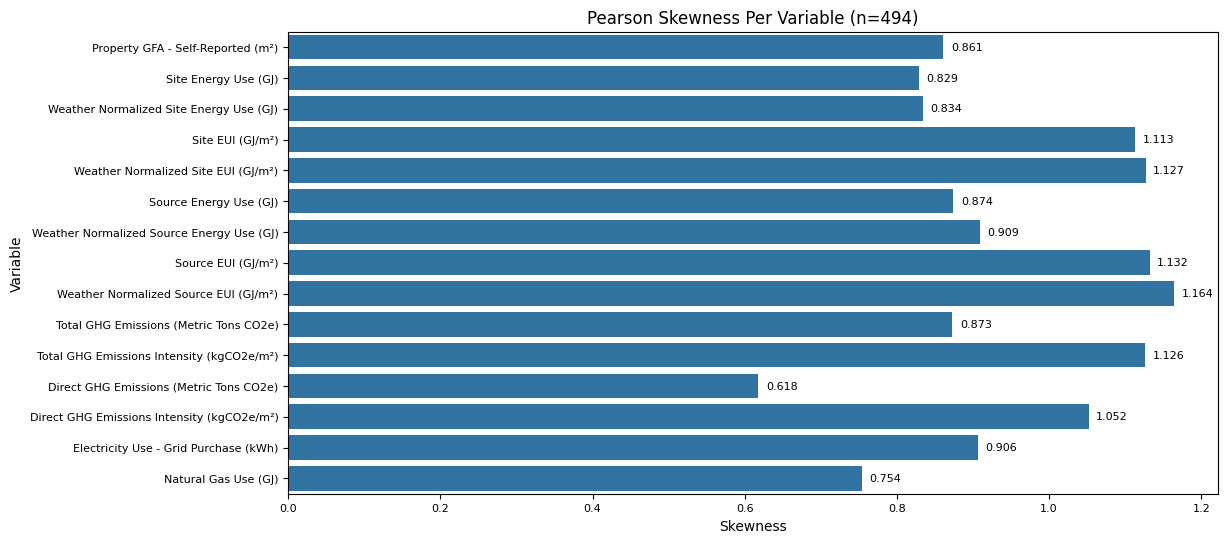

In [13]:
#Checking for Pearson Skewness Index according to the formula above for all the numerical columns:
skewness = []
for i in df.columns[9:-2]:
    mean = df[i].mean()
    median = df[i].quantile(0.5)
    std_v = df[i].std()
    p_skew = round(3*(mean - median)/std_v,3)
    skewness.append({'Variable': i, 'Skewness': p_skew})
final_skew = pd.DataFrame(skewness)
plt.figure(figsize=(12, 6))
sns.barplot(data=final_skew,x='Skewness',y='Variable')
plt.tick_params(labelsize=8)
plt.title('Pearson Skewness Per Variable (n=494)')
for index, row in final_skew.iterrows():
    plt.text(row['Skewness'] +0.01, index, str(row["Skewness"]), 
             va='center', fontsize=8)

**Outliers:** Using the IQR method, we can see that all the numerical columns have outliers. The max value of some columns is, in some cases, 200x the median. With the chart below we can see the number of cases per column, considering that all columns have the same number of observations (n = 494).

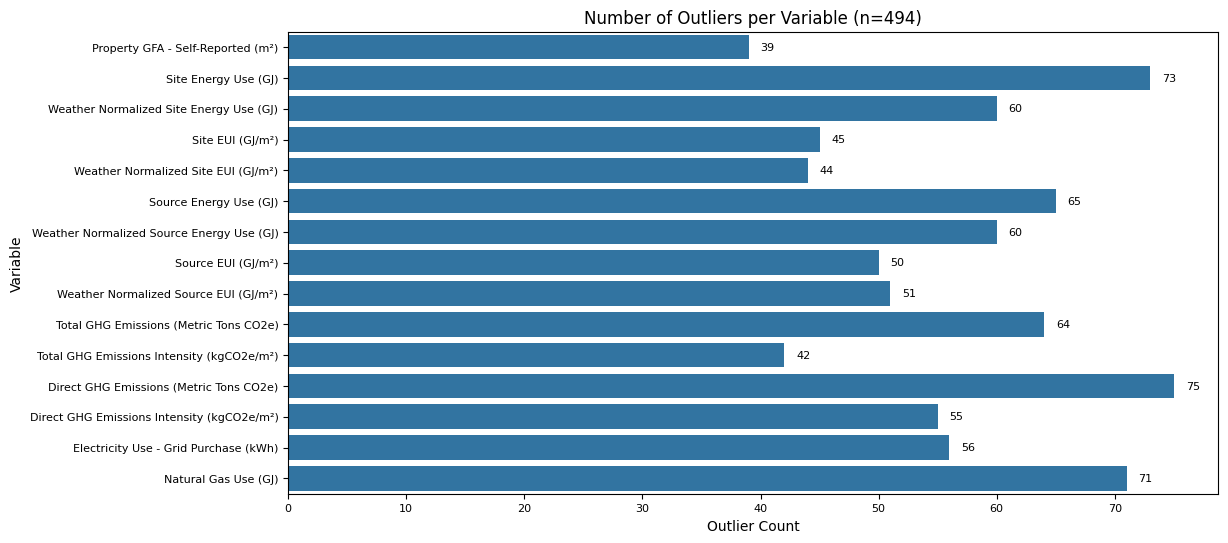

In [14]:
#Checking for Outliers using the IQR Method for all the numerical columns:
outliers = []
for i in df.columns[9:-2]:
    iqr = df[i].quantile(0.75) - df[i].quantile(0.25)
    lower = df[i].quantile(0.25)-1.5*iqr
    higher = df[i].quantile(0.75)+1.5*iqr
    count = ((df[i] < lower) | (df[i] > higher)).sum()
    outliers.append({'Variable': i, 'Outlier Count': count})
final_outliers = pd.DataFrame(outliers)
plt.figure(figsize=(12, 6))
sns.barplot(data=final_outliers,x='Outlier Count',y='Variable')
plt.tick_params(labelsize=8)
plt.title('Number of Outliers per Variable (n=494)')
for index, row in final_outliers.iterrows():
    plt.text(row['Outlier Count'] + 1, index, str(row["Outlier Count"]), 
             va='center', fontsize=8)

##### 2.2 Aggregations

Text(0.5, 1.0, 'Average EUI (GJ/m²) By Self Selected Property Type')

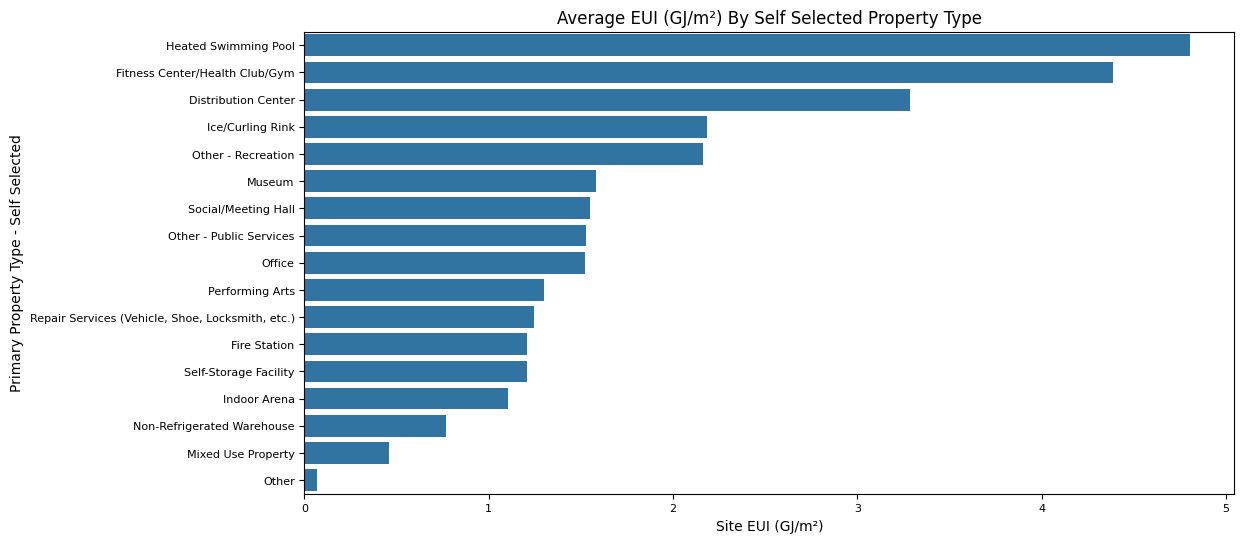

In [15]:
#Grouping Data of Site EUI per Property Type - Average
eui = df[['Primary Property Type - Self Selected','Site EUI (GJ/m²)']].groupby(by='Primary Property Type - Self Selected').mean().reset_index()
eui['Site EUI (GJ/m²)'] = round(eui['Site EUI (GJ/m²)'],3)
eui = eui.sort_values(by='Site EUI (GJ/m²)',ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=eui,x='Site EUI (GJ/m²)',y='Primary Property Type - Self Selected')
plt.tick_params(labelsize=8)
plt.title('Average EUI (GJ/m²) By Self Selected Property Type')

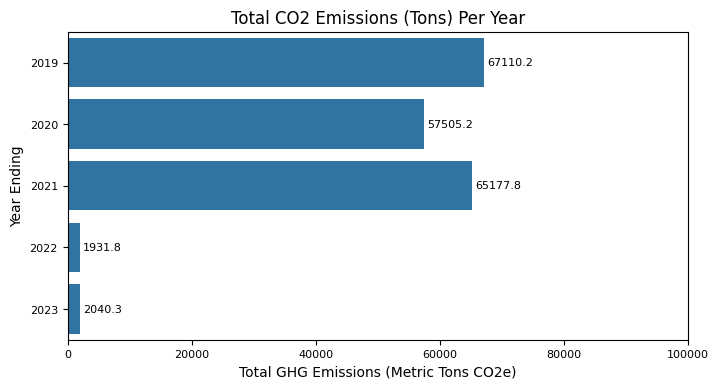

In [16]:
#Grouping Data of GHG Emissions per Year - Total
ghg = df[['Year Ending','Total GHG Emissions (Metric Tons CO2e)']].groupby(by='Year Ending').sum().reset_index()
ghg['Year Ending'] = ghg['Year Ending'].astype('category')
ghg['Total GHG Emissions (Metric Tons CO2e)'] = round(ghg['Total GHG Emissions (Metric Tons CO2e)'],1)

#Plotting chart of Sum of Metric Tons of CO2 per year
plt.figure(figsize=(8, 4))
sns.barplot(data=ghg,y='Year Ending',x='Total GHG Emissions (Metric Tons CO2e)')
plt.tick_params(labelsize=8)
plt.title('Total CO2 Emissions (Tons) Per Year')
plt.xlim(0,100000)
for index, row in ghg.iterrows():
    plt.text(row['Total GHG Emissions (Metric Tons CO2e)'] + 500, index, str(row["Total GHG Emissions (Metric Tons CO2e)"]), 
             va='center', fontsize=8)

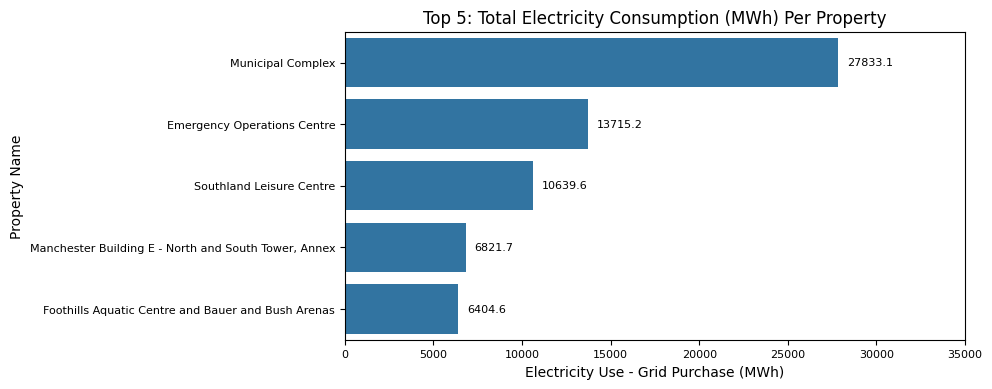

In [17]:
#Considering the entire database (All years), we have the Top 5 in Electricity Consumption as:
top_5_consumption = df[['Property Id', 'Property Name','Electricity Use - Grid Purchase (kWh)']].groupby(by=['Property Id', 'Property Name']).sum().sort_values(by='Electricity Use - Grid Purchase (kWh)',ascending=False)[:5].reset_index()

#Transforming kWh in MWh for better readability
top_5_consumption['Electricity Use - Grid Purchase (MWh)'] = round(top_5_consumption['Electricity Use - Grid Purchase (kWh)']/1000,1)

#Plotting chart of the Top 5 Properties in Electricity Consumption:
plt.figure(figsize=(8, 4))
sns.barplot(data=top_5_consumption,y='Property Name',x='Electricity Use - Grid Purchase (MWh)')
plt.tick_params(labelsize=8)
plt.title('Top 5: Total Electricity Consumption (MWh) Per Property')
plt.xlim(0,35000)
for index, row in top_5_consumption.iterrows():
    plt.text(row['Electricity Use - Grid Purchase (MWh)'] + 500, index, str(row["Electricity Use - Grid Purchase (MWh)"]), 
             va='center', fontsize=8)

##### 2.3 Detecting Outliers Using Regex and IQR

The incorrect/mismatched values were corrected on cell #7. Please find here again the loop used to correct these numbers. 

**The cell below should not be executed because it will result in error.**

In [18]:
# for i in ['Property GFA - Self-Reported (m²)','Site Energy Use (GJ)','Weather Normalized Site Energy Use (GJ)'
#           ,'Source Energy Use (GJ)','Weather Normalized Source Energy Use (GJ)','Total GHG Emissions (Metric Tons CO2e)'
#           ,'Direct GHG Emissions (Metric Tons CO2e)','Electricity Use - Grid Purchase (kWh)','Natural Gas Use (GJ)']:
#         df[i] = df[i].str.replace(r'[,]', '', regex=True).str.replace(r'(\d+)(\d{2})$', r'\1.\2', regex=True).astype(float)

In [19]:
#Checking for Outliers using the IQR Method for the variable 'Total GHG Emissions (Metric Tons CO2e)'
outliers = []
for i in ['Total GHG Emissions (Metric Tons CO2e)']:
    iqr = df[i].quantile(0.75) - df[i].quantile(0.25)
    lower = df[i].quantile(0.25)-1.5*iqr
    higher = df[i].quantile(0.75)+1.5*iqr
    count = ((df[i] < lower) | (df[i] > higher)).sum()
print('Column Total GHG Emissions (Metric Tons CO2e) contains ' + str(count) + ' outliers')

Column Total GHG Emissions (Metric Tons CO2e) contains 64 outliers


In [20]:
#Replacing Outliers in each column based on the median of the same Property Type
for i in df.columns[8:-2]:
    iqr = df[i].quantile(0.75) - df[i].quantile(0.25)
    lower = df[i].quantile(0.25)-1.5*iqr
    higher = df[i].quantile(0.75)+1.5*iqr
    outliers = (df[i] < lower) | (df[i] > higher)
    df.loc[outliers, i] = df[outliers].groupby('Primary Property Type - Self Selected')[i].transform('median')

#### Part 3: Data Visualization

##### 3.1 Time-Series Visualization

Text(0.5, 1.0, 'Average EUI (GJ/m²) By Year')

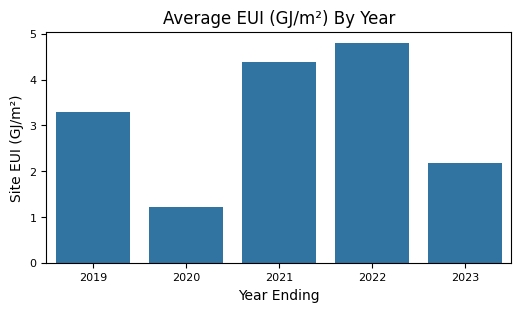

In [21]:
#Grouping Data of Site EUI by Year
eui_per_year = df[['Year Ending','Site EUI (GJ/m²)']].groupby(by='Year Ending').mean().reset_index()
eui_per_year['Site EUI (GJ/m²)'] = round(eui['Site EUI (GJ/m²)'],3)
plt.figure(figsize=(6, 3))
sns.barplot(data=eui_per_year,y='Site EUI (GJ/m²)',x='Year Ending')
plt.tick_params(labelsize=8)
plt.title('Average EUI (GJ/m²) By Year')

The chart above shows the average EUI (GJ/m2) per year and it is possible to see that during the acute years of the pandemic (2020 and 2021) we had a decrease in gas usage, probably because the two leaders in consumption on the database - Heated Swimming Pool (Avg of 5 GJ/m2) and Fitness Centers (avg of 4.4 GJ/m2) - were closed or with reduced capacity. 

However, because we have only 11 facilities within these two types, the movement was not as relevant as if, for example, we had closed Fire Stations, which the consumption is not as big (avg of 1.2 GJ/m2), but the population is quite high - 36 facilities.

##### 3.2 Comparative Bar Charts

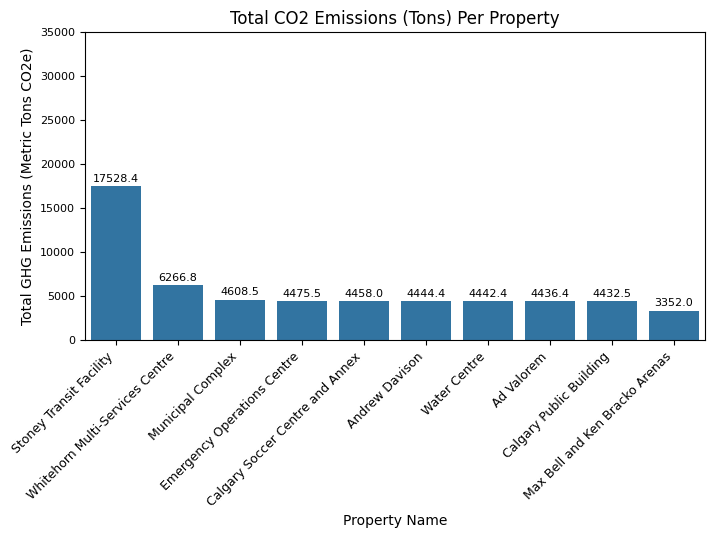

In [22]:
#Grouping Data of GHG Emissions per Property - Sum of All Years - Top 10
top_10_emissions = df[['Property Name','Total GHG Emissions (Metric Tons CO2e)']].groupby(by=['Property Name']).sum().sort_values(by='Total GHG Emissions (Metric Tons CO2e)',ascending=False)[:10].reset_index()
top_10_emissions['Total GHG Emissions (Metric Tons CO2e)'] = round(top_10_emissions['Total GHG Emissions (Metric Tons CO2e)'],1)

#Plotting chart of Sum of Metric Tons of CO2 per year
plt.figure(figsize=(8, 4))
sns.barplot(data=top_10_emissions,x='Property Name',y='Total GHG Emissions (Metric Tons CO2e)')
plt.tick_params(labelsize=8)
plt.title('Total CO2 Emissions (Tons) Per Property')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylim(0,35000)
for index, row in enumerate(top_10_emissions['Total GHG Emissions (Metric Tons CO2e)']):
    plt.text(index, row + 500, str(row), ha='center', fontsize=8)

##### 3.3 Heatmap Visualization

Text(0.5, 1.0, 'Average Site EUI (GJ/m²) Per Property Type By Year')

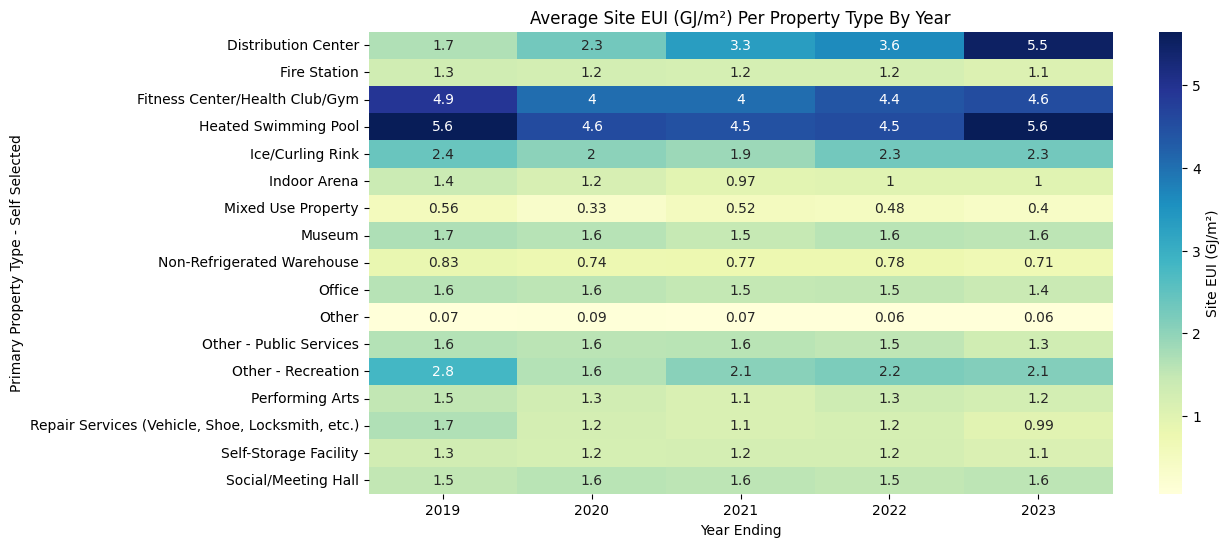

In [23]:
#Plotting Heatmap of EUI (GJ/m2) by Property Type per Year (2019-2023)
heatmap_df = df[['Year Ending','Primary Property Type - Self Selected','Site EUI (GJ/m²)']]
heatmap_df = heatmap_df.groupby(by=['Year Ending','Primary Property Type - Self Selected']).mean().reset_index()
heatmap_df = heatmap_df.pivot(index='Primary Property Type - Self Selected', columns='Year Ending', values='Site EUI (GJ/m²)')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Site EUI (GJ/m²)'})
plt.title('Average Site EUI (GJ/m²) Per Property Type By Year')

#### 4. Further Analysis

##### 4.1 Correlation Analysis

Text(0.5, 1.0, 'Correlation Energy Consumption, Total Emissions and Property Size')

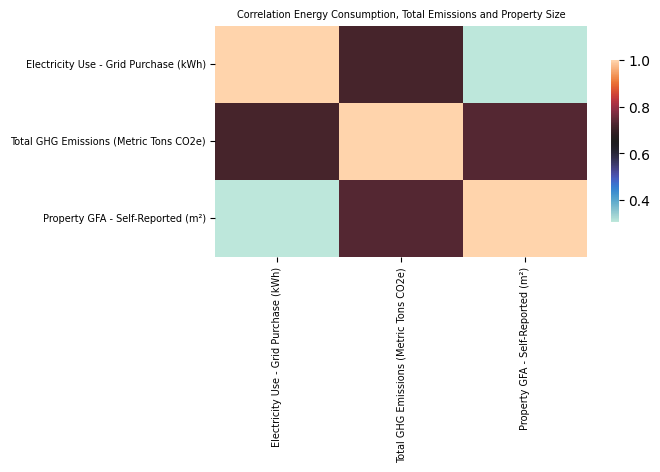

In [24]:
#Calculating the correlations: i. Energy Consumption (Electricity Use - Grid Purchase (kWh)), 

#ii. Emissions (Total GHG Emissions (Metric Tons CO2e)), iii. Building Size (Property GFA - Self-Reported (m²))

correlation = df[['Electricity Use - Grid Purchase (kWh)','Total GHG Emissions (Metric Tons CO2e)','Property GFA - Self-Reported (m²)']]
plt.figure(figsize=(6, 3))
sns.heatmap(correlation.corr(),annot_kws={"size": 7}, cbar_kws={'shrink': 0.7},cmap='icefire') 

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.title('Correlation Energy Consumption, Total Emissions and Property Size',fontsize=7)

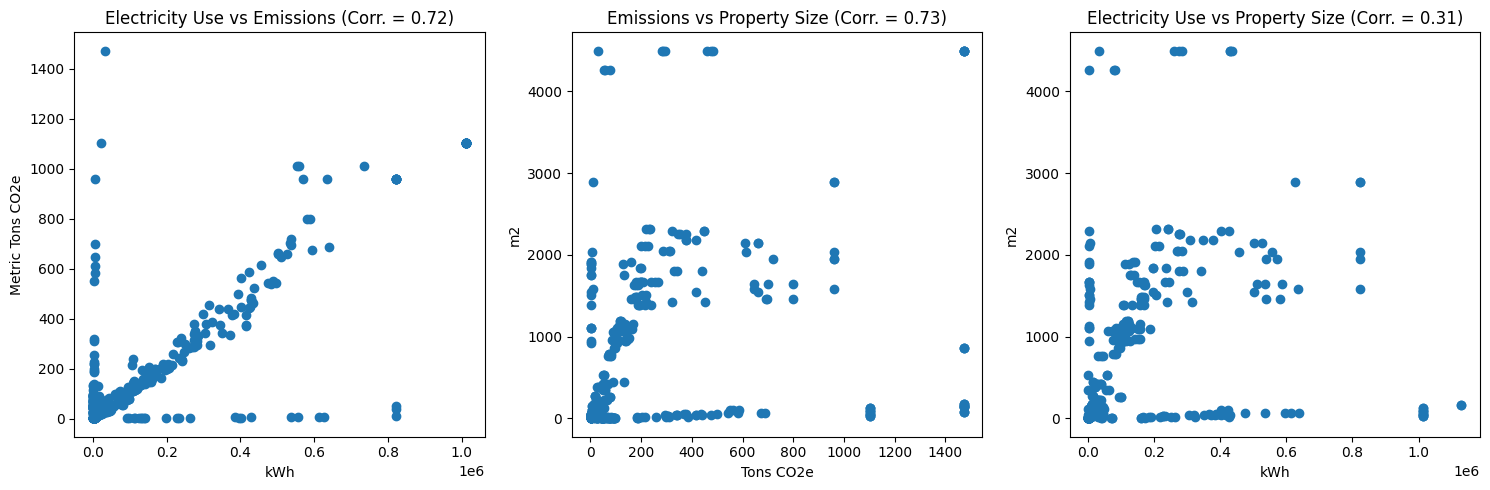

In [25]:
#Filtering Extreme Outliers for proper chart visualization
for i in correlation.columns:
    correlation[i] = correlation[i].loc[correlation[i] <= correlation[i].quantile(0.95)]

#Plotting charts to demonstrate correlations between variables    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(correlation['Electricity Use - Grid Purchase (kWh)'],correlation['Total GHG Emissions (Metric Tons CO2e)']) 
axes[0].set_title('Electricity Use vs Emissions (Corr. = 0.72)')
axes[0].set_ylabel('Metric Tons CO2e')
axes[0].set_xlabel('kWh')

axes[1].scatter(correlation['Total GHG Emissions (Metric Tons CO2e)'],correlation['Property GFA - Self-Reported (m²)'])
axes[1].set_title('Emissions vs Property Size (Corr. = 0.73)')
axes[1].set_xlabel('Tons CO2e')
axes[1].set_ylabel('m2')

axes[2].scatter(correlation['Electricity Use - Grid Purchase (kWh)'],correlation['Property GFA - Self-Reported (m²)']) 
axes[2].set_title('Electricity Use vs Property Size (Corr. = 0.31)')
axes[2].set_xlabel('kWh')
axes[2].set_ylabel('m2')
plt.tight_layout()

The charts above (alongside with the Correlation Matrix) highlights a **strong correlation between GHG emissions and Electricity Consumption**. This outcome is expected, as Alberta primarily generates electricity by burning natural gas, which produces CO2 and other greenhouse gases.

Additionally, **emissions are strongly correlated with property size** since emissions account for both electricity and gas consumption. While electricity use doesn’t appear to be directly related to property size, gas consumption is—larger properties require more energy for heating.

On the other hand, the **correlation between electricity use and property size is relatively weak (~ 0.3)**. This suggests that advancements in technology, such as energy-efficient equipment and LED lighting, have significantly reduced electricity demand. A few years ago, when fluorescent bulbs were more common, energy consumption was much higher.

##### 4.2 Hypothesis Testing

In [26]:
#To Perform this task, we will need to import the original table, 
#since we dropped the column ENERGY STAR Score because it has 66.6% of Nulls (higher than the threshold of 40%)
df_original = pd.read_csv('c:/users/jbertti/downloads/Building_Energy_Benchmarking.csv')
df_original = df_original[['Primary Property Type - Self Selected','ENERGY STAR Score']].dropna(axis=0)

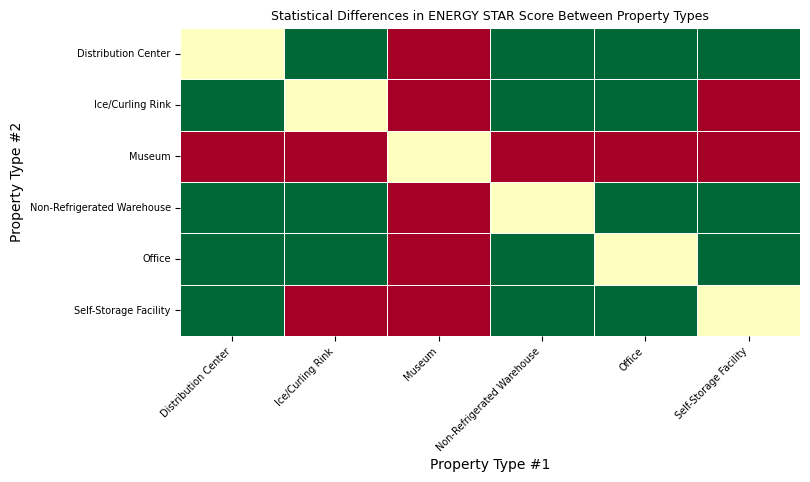

In [27]:
#Performing Hypothesis Testing between Energy Start Score and Property Types
total_combinations = list(permutations(df_original['Primary Property Type - Self Selected'].unique(),2))
t_test = []

alpha = 0.05

#Obtaining all combinations from Variables
for i in total_combinations:
    first = df_original.loc[df_original['Primary Property Type - Self Selected'] == i[0]]['ENERGY STAR Score']
    second = df_original.loc[df_original['Primary Property Type - Self Selected'] == i[1]]['ENERGY STAR Score']
    t_stat,p_val = stats.mannwhitneyu(first, second)
    t_test.append({'first':i[0],'second':i[1],'test_result':p_val})

test_df = pd.DataFrame(t_test)
test_df['StatDif'] = test_df['test_result'] < alpha
test_df = test_df.pivot(index='first', columns='second', values='StatDif')
test_df = test_df.astype(float).fillna(0.5)

#Plotting a Heatmap off all Statistical Tests (Red = No Statistical Difference, Green = Has Statistical Difference)
plt.figure(figsize=(8, 4))
sns.heatmap(test_df, cmap="RdYlGn", annot=False,cbar=False, fmt=".0f", linewidths=0.5)
plt.title('Statistical Differences in ENERGY STAR Score Between Property Types',fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Property Type #1')
plt.ylabel('Property Type #2')
plt.tick_params(labelsize=7)

Due to the number of nulls (66.6%), it is hard to have a final conclusion about the **Energy Star Score and the Property Type**. However, with the data that we have, it is possible to see that Museums are, in general, not very much different from other types (no statistical difference with any of the other types).

On the other hand, most property types differ significantly from one another, which aligns with expectations—comparing an Office to an Ice/Curling Rink or a Distribution Center to a Self-Storage Facility isn’t meaningful.

Even with the caveat of the missing data, the results that we had are expected.

#### 5. Reporting and Insights

##### 5.1 Summary Report

The data presented in this notebook covers some aspects regarding Energy Consumption, Gas Emissions, and other characteristics related to different properties in Alberta.

One important aspect that we did not take into consideration due to the lack of data is the monthly behavior of these metrics since we know that consumption is highly correlated with the temperature - for example, in a cold month, gas consumption is much higher than in a hot month.

Also, the dataset presented a few issues such as the number of outliers in almost every numerical column, which contributed to the skewness (presented in cells 13 and 14). With this imbalance in the data, a proper conclusion or good insights are hard to obtain. 

Moreover, we had to use Regular Expressions to reformat some values in the numerical columns, transform the Postal Code to the standard that is the norm in Canada (A1A 1A1), and extract data from other columns such as Address and Property Name.

Nevertheless, the dataset presented some insights such as:

**Emissions (Tons CO2)**: except Stoney Transit Facility, all other properties seem to be aligned in this metric. From the top 10, for example, Stoney Transit produced 17 MTons of CO2, while all other 9 produced between 3 and 6 MTons.

**Electricity Consumption (MWh)**: similarly to Emissions, there is one outstanding Property in Electricity Consumption - Municipal Complex. This property consumed over 4 years 27,833 MWh, double what the Top 2 consumed (13,715 MWh). Due to being a complex of the city hall and near buildings, it is expected to have a high consumption, but seeing the Double of the second higher consumption was not expected.

**Energy Use Intensity**: the average of EUI (GJ/m2) is, in most cases, stable and flat over the years. The only exception is the Distribution Centers, which grew significantly from 2019 to 2023 - from 1.7 to 5.5.

**Data Correlation**: the correlation between Gas Emissions and Electricity was expected due to the way it is produced. However, it is interesting to see the lack of a direct correlation between the size of the property and electricity consumption. It appears that in the past years were created some good solutions that will save Power without compromising the benefits. A different thing happens with Gas because it is more tangible and its use increases with the size because the majority of venues and houses have a central system that distributes the heat uniformly.

**In conclusion**, with the advance of Solar Energy and electrification, doing the same analysis 10 years in the future, it is likely that the results will be completely different. Energy efficiency will grow and lower the usage, while the emissions will certainly drop due to less Natural Gas being burned to produce heat and/or power. All of these advancements are already under research by the companies and will certainly benefit the consumer - alongside the World.